In [2]:
# Import Torch
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Support libraries 
import matplotlib.pyplot as plt
import numpy as np

# For reporducibility
torch.manual_seed(42)
np.random.seed(42)

# using Gpu device if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")
device


Running on cuda.


device(type='cuda')

In [7]:
import torch.utils.data as data

In [48]:
# Defining a transformation pipeline
transform = transforms.Compose([transforms.ToTensor()])

# We'll use torchvision to load Fashion MNIST trainset
trainset_data = torchvision.datasets.FashionMNIST(root='./data',
                                                  train=True,
                                                  download=True,
                                                  transform=transform)
# Create a data loader for trainset
train_load = data.DataLoader(trainset_data, batch_size=64, shuffle=True, num_workers=2)

# Similarly, load the testset of Fashion MNIST
testset_data = torchvision.datasets.FashionMNIST(root='./data',
                                                  train=False,
                                                  download=True,
                                                  transform=transform)
# Create a data loader for testset
test_load = data.DataLoader(testset_data, batch_size=64, shuffle=True, num_workers=2)

# We save the respective output of the neuron and the name of each classes
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal', 'Shirt', 'Sneaker','Bag','Ankle boot']

In [50]:
dataiter = iter(train_load)
dataiter

images, labels = next(dataiter)

images = np.squeeze(images)

In [51]:
images.shape

torch.Size([64, 28, 28])

C:\Users\danie\AppData\Local\Temp\ipykernel_23592\1231048956.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


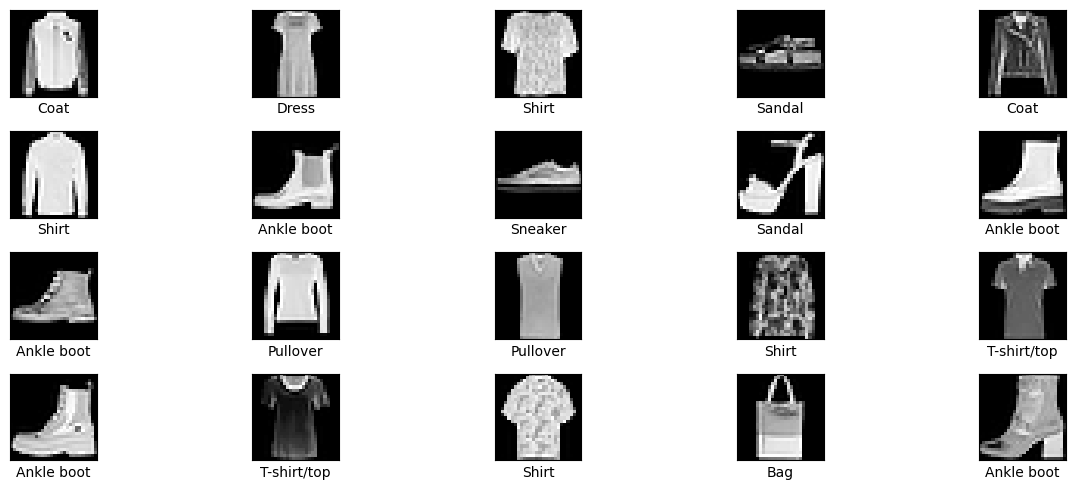

In [52]:
# Showing the images
fig = plt.figure(figsize=(15,5))
for i in np.arange(20):
    ax = fig.add_subplot(4,int(20/4),i+1, xticks=[],yticks=[])
    # plt.xticks([])
    # plt.yticks([])
    #plt.grid(False)
    ax.imshow(np.squeeze(images[i]),cmap='gray')
    ax.set_xlabel(class_names[labels[i].item()])
    fig.tight_layout()
fig.show()

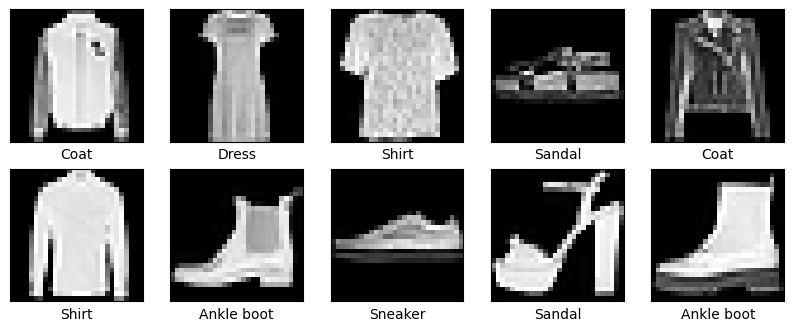

In [53]:
# Showing the images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].reshape(28,28),cmap='gray')
    plt.xlabel(class_names[labels[i].item()])
plt.show()

In [58]:
# Definition of the class CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Input: [batch_size, 1, 28, 28]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, padding=0)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=2, padding=0)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32*6*6,256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [59]:
# Asign the model to the cuda or cpu
model = CNN().to(device)

In [60]:
# Define the optimizer and the criterion
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [63]:
# Number of complete passes through the dataset
num_epochs = 10

# Start the training
for epoch in range(num_epochs):
    # Initialize a variable to keep track of the cumulative loss
    running_loss = 0.0
    # Set the model to training mode
    model.train()

    # Iterate over each batch of the training data 
    for images, labels in train_load:
        # Asign the computational device to run CPU or Cuda
        images, labels = images.to(device), labels.to(device)

        # Clear the gradients from previous iteration
        optimizer.zero_grad()

        # Foward pass: pass the images throught the model to get  the predicted outputs
        outputs = model(images)

        # Compute the loss between the predicted outputs and the true labels
        loss = criterion(outputs, labels)

        # Backward pass: compute the gradient of the loss
        loss.backward()
        
        # Update the model parameters
        optimizer.step()

        # Updating the running loss
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_load):.4f}, Accuracy: {1-running_loss/len(train_load):.4f}") 


Epoch [1/10], Loss: 0.0422, Accuracy: 0.9578
Epoch [2/10], Loss: 0.0413, Accuracy: 0.9587
Epoch [3/10], Loss: 0.0364, Accuracy: 0.9636
Epoch [4/10], Loss: 0.0330, Accuracy: 0.9670
Epoch [5/10], Loss: 0.0314, Accuracy: 0.9686
Epoch [6/10], Loss: 0.0253, Accuracy: 0.9747
Epoch [7/10], Loss: 0.0261, Accuracy: 0.9739
Epoch [8/10], Loss: 0.0246, Accuracy: 0.9754
Epoch [9/10], Loss: 0.0243, Accuracy: 0.9757
Epoch [10/10], Loss: 0.0196, Accuracy: 0.9804


In [64]:
# Impor other support libraries
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [65]:
# Set the model to evaluation mode
model.eval()

# lists to store all predictions and true labels
all_preds = []
all_labels = []

# We don't want to compute the gradients during evaluation 
with torch.no_grad():
    # Iterate all over the batches in test loader
    for images, labels in test_load:
        # Asign the computational device to run CPU or Cuda
        images, labels = images.to(device), labels.to(device)

        # Pass the images through the model to get predictions
        outputs = model(images)

        # Get the class with the maximum probabilities as the predicted class
        _, predicted = torch.max(outputs, 1)

        # Extend the all_preds list with predictions
        all_preds.extend(predicted.cpu().numpy())

        # Extend the all_labels list with the true labels
        all_labels.extend(labels.cpu().numpy())

# Print a classification report which provides an overview of the model
print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

 T-shirt/top       0.86      0.87      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.83      0.87      0.85      1000
       Dress       0.92      0.91      0.91      1000
        Coat       0.81      0.90      0.85      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.80      0.68      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [66]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

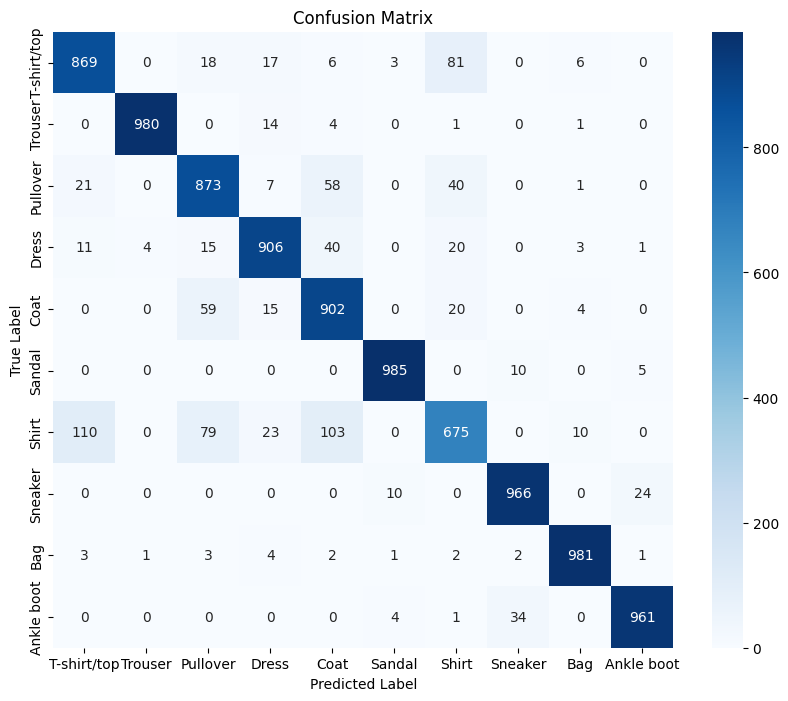

In [67]:
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Aditional confusion with sankey

In [68]:
import pandas as pd
from plotly import graph_objects as go

In [69]:
RED = "rgba(245,173,168,0.6)"
GREEN = "rgba(211,255,216,0.6)"

In [70]:
def create_df_from_confusion_matrix(confusion_matrix, class_labels=None):
    
    
    ## create a dataframe
    if not len(class_labels):
        ## if class labels not received, created dummy headers and index
        df = pd.DataFrame(data=confusion_matrix, 
                          index=[f"True Class-{i+1}" for i in range(confusion_matrix.shape[0])],
                          columns=[f"Predicted Class-{i+1}" for i in range(confusion_matrix.shape[0])])
    else:
        ## create headers and index using class labels
        df = pd.DataFrame(data=confusion_matrix, 
                          index=[f"True {i}" for i in class_labels],
                          columns=[f"Predicted {i}" for i in class_labels])
    
    ## unpivot dataframe and rename columns
    df = df.stack().reset_index()
    df.rename(columns={0:'instances', 'level_0':'actual', 'level_1':'predicted'}, inplace=True)
    """
    >>> df
            actual          predicted     instances
          True Fraud    Predicted Fraud       10
          True Fraud    Predicted Legit       4
          True Legit    Predicted Fraud       2
          True Legit    Predicted Legit       12
    
    """
    
    ## determine classification color based on correct classification or not.
    df["colour"] = df.apply(lambda x: 
                               GREEN if x.actual.split()[1:] == x.predicted.split()[1:] 
                               else RED, axis=1)

    node_labels = pd.concat([df.actual, df.predicted]).unique()
    node_labels_indices = {label:index for index, label in enumerate(node_labels)}
    
    ## map actual and predicted columns to numbers
    df =  df.assign(actual    = df.actual.apply(lambda x: node_labels_indices[x]),
                    predicted = df.predicted.apply(lambda x: node_labels_indices[x]))
    
    ## determine text for hovering on connecting edges of sankey diagram
    def get_link_text(row):
        if row["colour"] == GREEN:
            instance_count = row["instances"]
            source_class = ' '.join(node_labels[row['actual']].split()[1:])
            target_class = ' '.join(node_labels[row['predicted']].split()[1:])
            return f"{instance_count} {source_class} instances correctly classified as {target_class}"
        else:
            instance_count = row["instances"]
            source_class = ' '.join(node_labels[row['actual']].split()[1:])
            target_class = ' '.join(node_labels[row['predicted']].split()[1:])
            return f"{instance_count} {source_class} instances incorrectly classified as {target_class}"
        
    df["link_text"] = df.apply(get_link_text, axis = 1)
    return df, node_labels
    

def plot_confusion_matrix_as_sankey(confusion_matrix,  class_labels = None):
    
    """
    plots sankey diagram from confusion matrix and class labels
    
    The function acceps:
        - confusion_matrix
                [[TP, FN]
                 [FP, TN]]
        - class_labels:
            class_labels[0]: Label for positive class
            class_labels[1]: Label for negative class
        
    """
    
    df, labels = create_df_from_confusion_matrix(confusion_matrix,  class_labels)
    
    fig = go.Figure(data=[go.Sankey(
    
    node = dict(
      pad = 20,
      thickness = 20,
      line = dict(color = "gray", width = 1.0),
      label = labels,
      hovertemplate = "%{label} has total %{value:d} instances<extra></extra>"
    ),
    link = dict(
      source = df.actual, 
      target = df.predicted,
      value = df.instances,
      color = df.colour,
      customdata = df['link_text'], 
      hovertemplate = "%{customdata}<extra></extra>"  
    ))])

    fig.update_layout(title_text="Confusion Matrix Sankey Diagram", font_size=15,
                      width=500, height=400)
    
    return fig

In [71]:
plot_confusion_matrix_as_sankey(cm, class_names)